<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment_2/blob/main/Assignment_2_QA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import shutil

# Source folder in Google Drive
src_folder = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 2/inaturalist_12K'

# Destination in Colab's local storage
dst_folder = '/content/inaturalist_12K'

# Copy the entire folder
shutil.copytree(src_folder, dst_folder)

'/content/inaturalist_12K'

In [4]:
# ------------------------------
# Device setup for Colab
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ------------------------------
# CNN Model Definition
# ------------------------------
class FlexibleCNN(nn.Module):
    def __init__(self,
                 in_channels=3,                           # Number of input channels (e.g., 3 for RGB)
                 conv_channels=[32, 64, 128, 256, 512],   # Number of filters in each conv layer
                 kernel_sizes=[3, 3, 3, 3, 3],            # Filter sizes for each conv layer
                 activation_fn=nn.ReLU(),                 # Activation function (flexible)
                 batch_norm=True,                         # Batch normalization flag
                 dense_size = 256,                       # Number of neurons in final dense layer
                 dropout_prob=0.3,                        # Dropout probability
                 num_classes=10,                          # Number of output classes
                 input_size=224):                         # Size of the input image (assumed square)

        super(FlexibleCNN, self).__init__()

        self.activation_fn = activation_fn
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_prob)

        layers = []
        current_in_channels = in_channels

        # Create convolutional blocks:
        # Conv -> BatchNorm -> Activation -> Pool -> Dropout
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers.append(nn.Conv2d(current_in_channels, out_channels,
                                    kernel_size=kernel_size, padding= kernel_size // 2))

            if batch_norm==True:
              layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization

            layers.append(activation_fn)                # Activation
            layers.append(self.pool)                    # Max pooling
            layers.append(nn.Dropout2d(dropout_prob))   # Spatial dropout
            current_in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # Compute size after downsampling through pooling
        reduced_size = input_size // (2 ** len(conv_channels))  # Image is halved after each pool
        self.flatten_dim = current_in_channels * reduced_size * reduced_size

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, dense_size)      # Dense hidden layer
        self.activ_fc1 = activation_fn                        # Activation
        self.fc_dropout = nn.Dropout(dropout_prob)        # Dropout before output
        self.output = nn.Linear(dense_size, num_classes)         # Output layer

    def forward(self, x):
        x = self.conv_layers(x)             # Pass through conv blocks
        x = x.view(x.size(0), -1)           # Flatten
        x = self.fc1(x)                     # Fully connected hidden layer
        x = self.activ_fc1(x)               # activation
        x = self.fc_dropout(x)              # Dropout
        x = self.output(x)                  # Output logits
        return x

# ------------------------------
# Training Function
# ------------------------------
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()                   # Zero gradients
        outputs = model(inputs)                 # Forward pass
        loss = criterion(outputs, labels)       # Compute loss
        loss.backward()                         # Backward pass
        optimizer.step()                        # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)           # Get predicted class
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total


# ------------------------------
# Evaluation Function
# ------------------------------
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in tqdm(loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_total += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return loss_total / len(loader), correct / total


# ------------------------------
# Dataloader
# ------------------------------
def load_split_dataset(dataset_path, train_ratio = 0.8, data_aug = False ,batch_size=64):

  if data_aug == True:
    transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
      transforms.ToTensor(),
      transforms.Normalize([0.5]*3, [0.5]*3)
    ])
  else:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # resize to a common shape
        transforms.ToTensor(),          # convert image to PyTorch tensor
        transforms.Normalize([0.5]*3, [0.5]*3)  # normalize (assuming RGB images)
    ])


  full_train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

  # Set your train/val split ratio
  total_size = len(full_train_dataset)
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  # Split the dataset
  train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

  # check counts
  print(f"Total images: {total_size}")
  print(f"Training images: {len(train_dataset)}")
  print(f"Validation images: {len(val_dataset)}")

  return train_loader, val_loader

Using device: cuda


In [5]:
import wandb

In [9]:
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
run = wandb.init(entity="arunangshudutta218-iitm", project='dl_assgn_2_q_A4_t2')


num_filter = 32
filter_org = 'same'
batch_norm = 'yes'
data_aug = 'yes'
dropout = 0.2
learning_rate = 0.0001
activation = 'SiLU'
dense_size = 256
num_conv_layer = 3


if  num_conv_layer == 3:
    if filter_org == 'same':
      no_of_filters=[num_filter, num_filter, num_filter]
    elif filter_org=='double' :
      no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter]
    elif filter_org == 'half' :
      no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter)]
else:
    if filter_org == 'same':
      no_of_filters=[num_filter, num_filter, num_filter, num_filter, num_filter]
    elif filter_org=='double' :
      no_of_filters=[num_filter, (2**1)*num_filter, (2**2)*num_filter, (2**3)*num_filter, (2**4)*num_filter]
    elif filter_org == 'half' :
      no_of_filters=[num_filter, int((0.5**1)*num_filter), int((0.5**2)*num_filter),
                      int((0.5**3)*num_filter), int((0.5**4)*num_filter)]

if activation == 'ReLU':
  act_func = nn.ReLU()
elif activation == 'GELU':
  act_func = nn.GELU()
elif activation == 'SiLU':
  act_func = nn.SiLU()
elif activation == 'Mish':
  act_func = nn.Mish()

if batch_norm == 'yes':
  batch_norm = True
else:
  batch_norm = False

if data_aug == 'yes':
  data_aug = True
else:
  data_aug = False


wandb.run.name = "f_{}_conv_{}_org_{}_norm_{}_aug_{}_drop_{}_lr_{}_ac_{}_ds_{}".format(num_filter, num_conv_layer, filter_org,
                                                                                  batch_norm, data_aug, dropout,
                                                                                  learning_rate, activation, dense_size)

# ------------------------------
# Dataloader
# ------------------------------

dataset_path = '/content/inaturalist_12K/train/'
train_loader, val_loader = load_split_dataset(dataset_path, train_ratio = 1, data_aug = data_aug , batch_size=64)

dataset_path = '/content/inaturalist_12K/val/'
test_loader, none_load = load_split_dataset(dataset_path, train_ratio = 1, data_aug = data_aug , batch_size=64)

# ------------------------------
# Model
# ------------------------------

model = FlexibleCNN(
    in_channels=3,
    conv_channels=no_of_filters,
    kernel_sizes=[3, 3, 3, 3, 3],
    dense_size = dense_size,
    activation_fn= act_func,
    batch_norm=batch_norm,
    dropout_prob= dropout,
    num_classes=10,
    input_size=224
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    # Adam optimizer
criterion = nn.CrossEntropyLoss()                              # Cross-entropy for classification


# ------------------------------
# Main Training Loop
# ------------------------------
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    #val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}%")
    #print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc*100:.2f}%")
    print(f"Test   Loss: {test_loss:.4f} | Test   Accuracy: {test_acc*100:.2f}%")

    #wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'val_loss' : val_loss, 'val_accuracy' : val_acc, 'test_loss' : test_loss, 'test_accuracy' : test_acc})
    wandb.log({'tr_loss' : train_loss, 'tr_accuracy' : train_acc, 'test_loss' : test_loss, 'test_accuracy' : test_acc})



run.finish()

model_path = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 2/cnn_model.pth'
torch.save(model.state_dict(), model_path)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total images: 9999
Training images: 9999
Validation images: 0
Total images: 2000
Training images: 2000
Validation images: 0

Epoch 1/10


Train Loss: 2.1837 | Train Accuracy: 20.38%
Test   Loss: 2.0328 | Test   Accuracy: 28.70%

Epoch 2/10


Train Loss: 2.0714 | Train Accuracy: 26.19%
Test   Loss: 1.9833 | Test   Accuracy: 30.90%

Epoch 3/10


Train Loss: 2.0303 | Train Accuracy: 27.77%
Test   Loss: 1.9444 | Test   Accuracy: 32.30%

Epoch 4/10


Train Loss: 2.0001 | Train Accuracy: 28.92%
Test   Loss: 1.9190 | Test   Accuracy: 34.20%

Epoch 5/10


Train Loss: 1.9791 | Train Accuracy: 30.14%
Test   Loss: 1.9070 | Test   Accuracy: 33.35%

Epoch 6/10


Train Loss: 1.9689 | Train Accuracy: 30.44%
Test   Loss: 1.9105 | Test   Accuracy: 32.95%

Epoch 7/10


Train Loss: 1.9472 | Train Accuracy: 31.06%
Test   Loss: 1.9109 | Test   Accuracy: 34.45%

Epoch 8/10


Train Loss: 1.9271 | Train Accuracy: 31.90%
Test   Loss: 1.8720 | Test   Accuracy: 34.20%

Epoch 9/10


Train Loss: 1.9264 | Train Accuracy: 32.04%
Test   Loss: 1.8717 | Test   Accuracy: 35.30%

Epoch 10/10


Train Loss: 1.9170 | Train Accuracy: 31.88%
Test   Loss: 1.8812 | Test   Accuracy: 34.90%


test_accuracy,▁▃▅▇▆▆▇▇██
test_loss,█▆▄▃▃▃▃▁▁▁
tr_accuracy,▁▄▅▆▇▇▇███
tr_loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,0.349
test_loss,1.88118
tr_accuracy,0.31883
tr_loss,1.91695


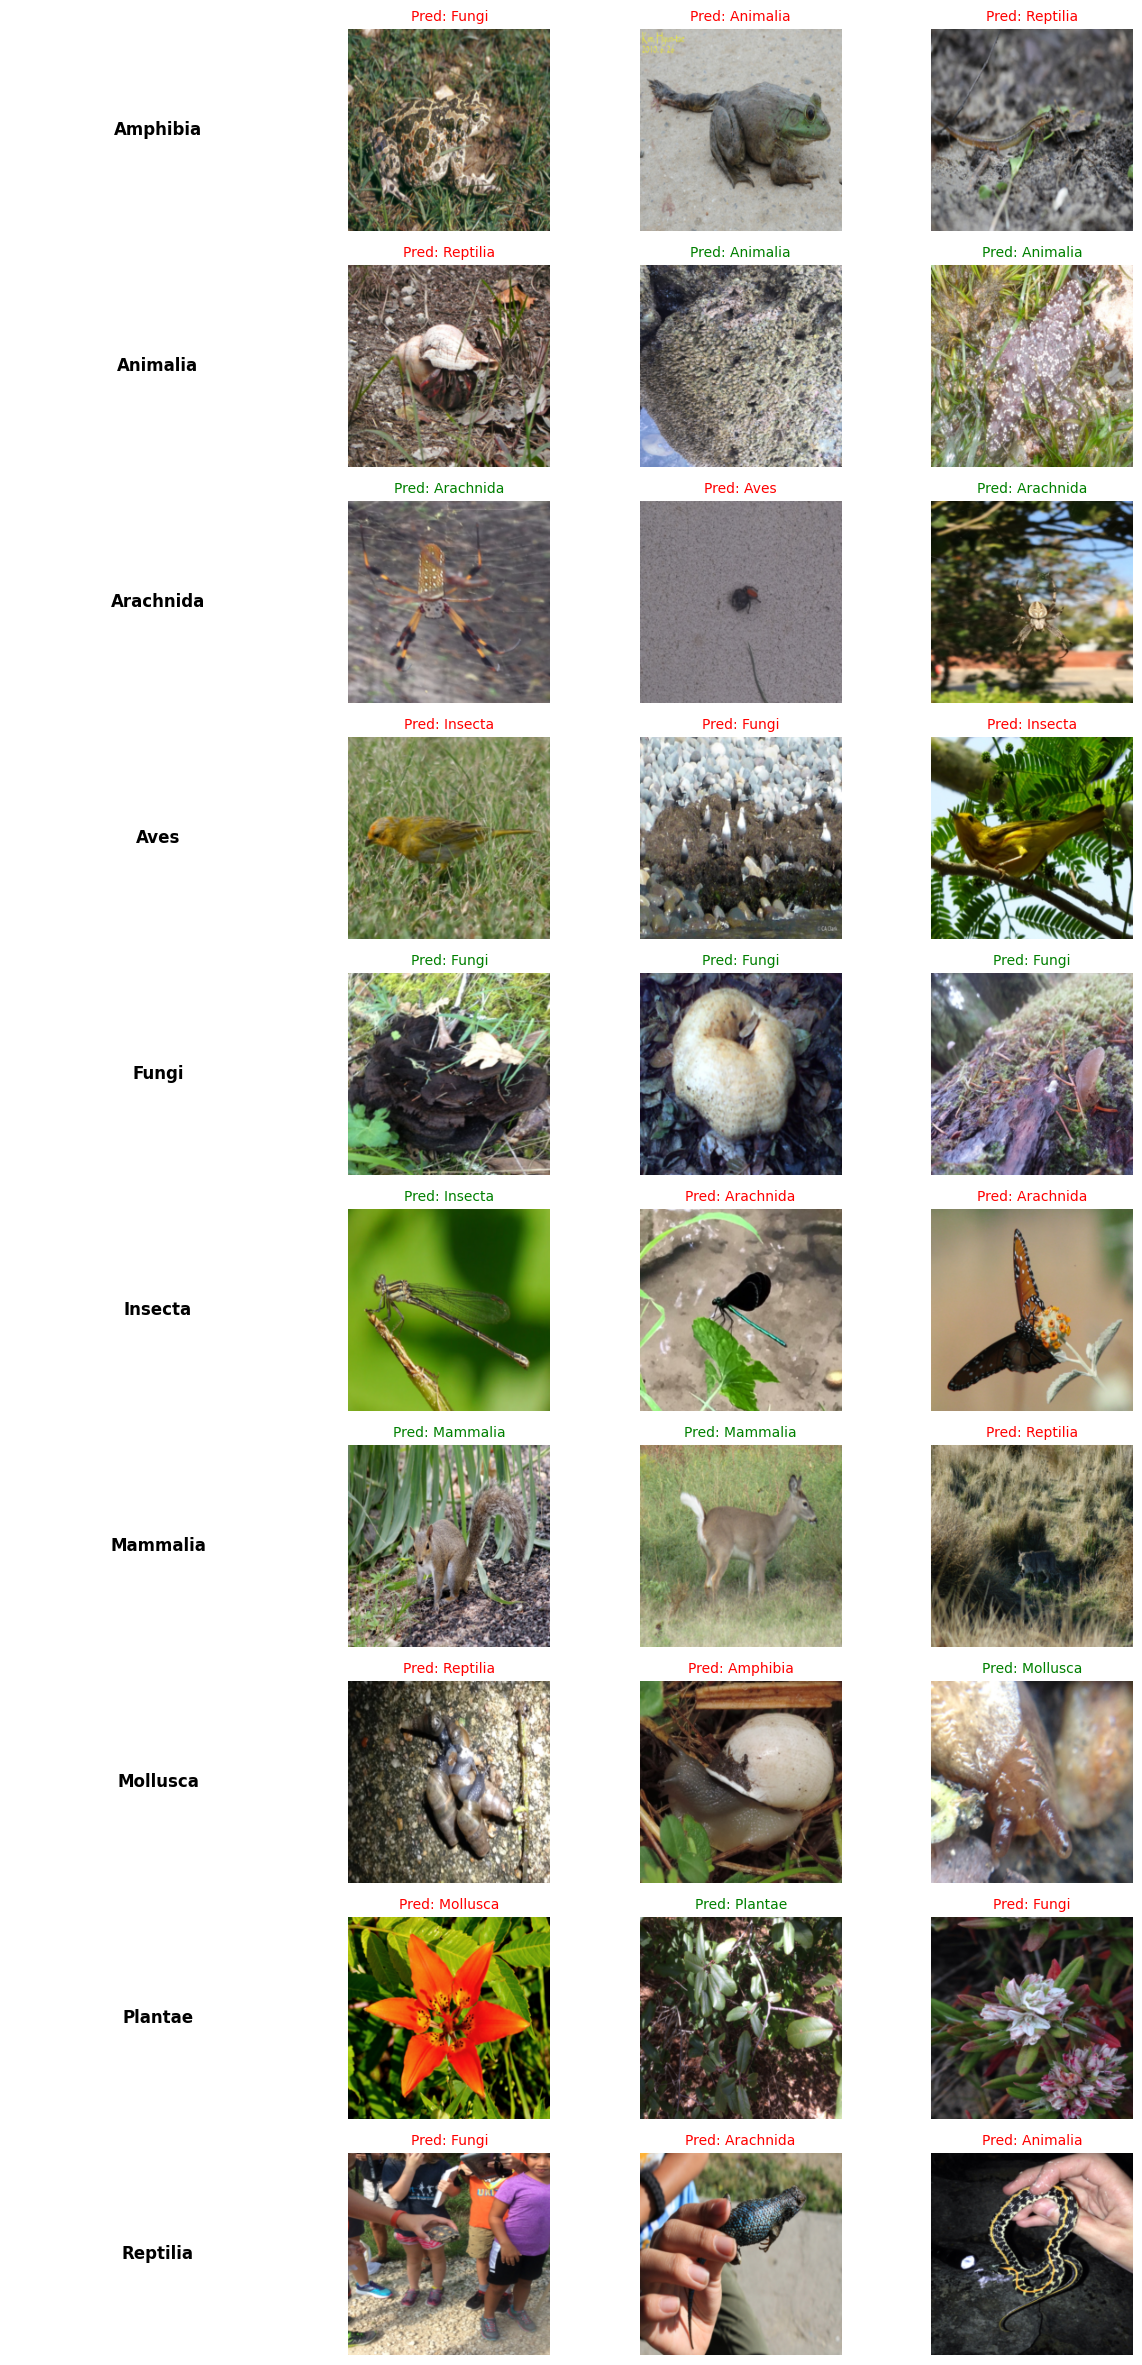

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ===== CONFIG =====
root_folder = '/content/inaturalist_12K/val/'
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to a common shape
    transforms.ToTensor(),          # convert image to PyTorch tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize (assuming RGB images)
])

# ===== Load 3 images per class from folder =====
def load_images_per_class(folder, transform, max_images=3):
    class_samples = {}
    class_names = sorted(os.listdir(folder))

    for cls in class_names:
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue

        images = []
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(cls_path, fname)
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img)
                images.append(img_tensor)
                if len(images) == max_images:
                    break
        class_samples[cls] = images
    return class_samples, class_names

# ===== Visualization helper =====
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# ===== Predict & Plot =====
class_samples, class_names = load_images_per_class(root_folder, transform)

fig, axes = plt.subplots(nrows=len(class_names), ncols=4, figsize=(12, 25))
#fig.suptitle("Image Predictions from Folder", fontsize=20, y=0.92)

for row_idx, class_name in enumerate(class_names):
    row_axes = axes[row_idx]
    images = class_samples[class_name]

    # Column 0: Class name
    row_axes[0].axis('off')
    row_axes[0].text(0.5, 0.5, class_name, ha='center', va='center', fontsize=12, fontweight='bold')

    for col_idx in range(3):
        ax = row_axes[col_idx + 1]
        if col_idx < len(images):
            img_tensor = images[col_idx].unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)

            pred_class = class_names[pred.item()] if pred.item() < len(class_names) else f"class {pred.item()}"
            ax.imshow(imshow(images[col_idx].cpu()))
            ax.set_title(f"Pred: {pred_class}", fontsize=10,
                         color='green' if pred_class == class_name else 'red')
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [21]:
wandb.init(entity="arunangshudutta218-iitm", project='dl_assgn_2_q_A4_t3')
wandb.log({"Image Predictions": wandb.Image(fig)})